# Robust Inference under Alignment Assumptions  
## Case Study: Influenza A NS1

## Objective

To evaluate whether the robustness-based framework developed on HIV-1 Tat generalizes to a longer and structurally distinct viral protein.

The analysis quantifies how site-wise sequence variability depends on alignment assumptions and distinguishes alignment-robust positions from assumption-sensitive ones.

In [ ]:
!pip -q install biopython numpy pandas
!apt-get -qq update
!apt-get -qq install mafft
from Bio import Entrez, SeqIO
import random
import pandas as pd
from collections import Counter

Entrez.email = "tasosmelas5@gmail.com"  # change if needed

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


## Data Retrieval

Protein sequences annotated as *Influenza A NS1* were retrieved from the NCBI Protein database using a keyword-based query.

No subtype or strain restriction was applied at the retrieval stage.

In [ ]:
PROTEIN_NAME = "influenzaA_NS1"

QUERY = (
    '"Influenza A virus"[Organism] AND '
    '(NS1[Gene] OR "non-structural protein 1"[All Fields]) '
    'NOT partial[Title] NOT fragment[Title]'
)

POOL_RETMAX = 8000
N_SAMPLE = 300
SEED = 7

random.seed(SEED)

In [ ]:
h = Entrez.esearch(db="protein", term=QUERY, retmax=POOL_RETMAX)
r = Entrez.read(h)
h.close()

ids = r["IdList"]
print("Total hits:", r["Count"])
print("Retrieved IDs:", len(ids))
print("First IDs:", ids[:5])


Total hits: 165151
Retrieved IDs: 8000
First IDs: ['123879939', '123879910', '123874344', '123873624', '123873527']


In [ ]:
sample_ids = random.sample(ids, min(N_SAMPLE, len(ids)))
print("Sampled IDs:", len(sample_ids))
print("First sampled IDs:", sample_ids[:5])

Sampled IDs: 300
First sampled IDs: ['3140634983', '3130904019', '3048258424', '3138444140', '3138788558']


In [ ]:
def fetch_fasta(id_list, chunk=200):
    recs = []
    for i in range(0, len(id_list), chunk):
        batch = id_list[i:i+chunk]
        h = Entrez.efetch(
            db="protein",
            id=",".join(batch),
            rettype="fasta",
            retmode="text"
        )
        recs.extend(list(SeqIO.parse(h, "fasta")))
        h.close()
    return recs

records = fetch_fasta(sample_ids, chunk=200)
print("Downloaded sequences:", len(records))

Downloaded sequences: 300


## Initial Data Inspection

Retrieved sequences were inspected for length heterogeneity.

The length distribution was used to identify the dominant canonical NS1 length and to exclude partial, truncated, or anomalous records prior to downstream analysis.



In [ ]:
lengths = [len(rec.seq) for rec in records]

length_df = (
    pd.Series(lengths)
    .value_counts()
    .rename_axis("length")
    .reset_index(name="count")
    .sort_values("length")
)
length_df["freq"] = (length_df["count"] / length_df["count"].sum()).round(3)

length_df.tail(20)  # show the long-length tail (Spike should dominate near ~1273)


,length,count,freq
2,217,3,0.010
1,219,59,0.197
3,225,1,0.003
0,230,236,0.787
4,237,1,0.003


In [ ]:
print("Example records:")
for rec in records[:5]:
    print(rec.id, len(rec.seq))
    print(" ", rec.description)

Example records:
YCL62320.1 230
  YCL62320.1 nonstructural protein 1 [Influenza A virus]
YCB10502.1 219
  YCB10502.1 nonstructural protein 1 [Influenza A virus]
XZG48638.1 230
  XZG48638.1 nonstructural protein 1 [Influenza A virus]
YCJ53834.1 230
  YCJ53834.1 nonstructural protein 1 [Influenza A virus]
YCK03749.1 230
  YCK03749.1 nonstructural protein 1 [Influenza A virus]


## Sequence Curation

Sequences matching the dominant NS1 length were retained.

Exact duplicate sequences were removed to avoid redundancy-driven inflation of variability estimates.

The resulting dataset represents a non-redundant sample of NS1 sequence diversity.

In [ ]:
print("Min length:", min(lengths))
print("Max length:", max(lengths))

Min length: 217
Max length: 237


In [ ]:
LEN_MIN = 230
LEN_MAX = 230
filtered = [r for r in records if LEN_MIN <= len(r.seq) <= LEN_MAX]
print("Filtered:", len(filtered))

Filtered: 236


In [ ]:
def ambiguity_fraction(seq):
    return sum(aa in "XBZJU*" for aa in str(seq)) / len(seq)

clean = [r for r in filtered if ambiguity_fraction(r.seq) <= 0.05]
print("After ambiguity filter:", len(clean))

After ambiguity filter: 236


In [ ]:
seen = {}
for r in clean:
    s = str(r.seq)
    if s not in seen:
        seen[s] = r

dedup = list(seen.values())
print("After deduplication:", len(dedup))

After deduplication: 113


## Alignment Scenarios

Multiple sequence alignments were generated under different gap penalty regimes.

Each alignment represents a distinct but plausible alignment assumption.

All subsequent analyses were performed independently for each alignment scenario.


In [ ]:
from Bio import SeqIO

curated_path = f"{PROTEIN_NAME}_curated_{LEN_MIN}_{LEN_MAX}_dedup.fasta"
SeqIO.write(dedup, curated_path, "fasta")
print("Saved:", curated_path)

Saved: influenzaA_NS1_curated_230_230_dedup.fasta


In [ ]:
import subprocess

def ensure_mafft():
    try:
        subprocess.check_output(["mafft", "--version"], text=True)
        print("MAFFT found.")
    except Exception:
        print("Installing MAFFT...")
        subprocess.check_call(["bash", "-lc", "apt-get -qq update && apt-get -qq install -y mafft"])
        print("MAFFT installed.")

ensure_mafft()

MAFFT found.


In [ ]:
def run_mafft(in_fasta, out_fasta, op, ep):
    cmd = ["mafft", "--quiet", "--op", str(op), "--ep", str(ep), in_fasta]
    aln = subprocess.check_output(cmd, text=True)
    with open(out_fasta, "w") as f:
        f.write(aln)

SCENARIOS = {
    "gaps_expensive": {"op": 5.0, "ep": 0.5},
    "gaps_medium":    {"op": 2.0, "ep": 0.2},
    "gaps_cheap":     {"op": 0.5, "ep": 0.05},
}

aln_paths = {}
for name, p in SCENARIOS.items():
    out = f"{PROTEIN_NAME}_{name}.fasta"
    run_mafft(curated_path, out, p["op"], p["ep"])
    aln_paths[name] = out
    print("Saved alignment:", out)

Saved alignment: influenzaA_NS1_gaps_expensive.fasta
Saved alignment: influenzaA_NS1_gaps_medium.fasta
Saved alignment: influenzaA_NS1_gaps_cheap.fasta


In [ ]:
def read_fasta_dict(path):
    seqs = {}
    name = None
    chunks = []
    with open(path) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if name is not None:
                    seqs[name] = "".join(chunks)
                name = line[1:].strip()
                chunks = []
            else:
                chunks.append(line)
        if name is not None:
            seqs[name] = "".join(chunks)
    return seqs

print("Alignment inspection:\n")
for name, path in aln_paths.items():
    aln = read_fasta_dict(path)
    lengths = {len(seq) for seq in aln.values()}
    print(f"{name}: sequences={len(aln)} | alignment_lengths={lengths}")

Alignment inspection:

gaps_expensive: sequences=113 | alignment_lengths={230}
gaps_medium: sequences=113 | alignment_lengths={230}
gaps_cheap: sequences=113 | alignment_lengths={231}


## Site-wise Variability Metrics

For each alignment, site-wise metrics were computed, including:
- amino acid variability
- Shannon entropy
- gap frequency

Metrics were calculated independently per alignment to preserve assumption-specific effects.


In [ ]:
from math import log2
from collections import Counter
import pandas as pd

def shannon_entropy(chars):
    chars = [c for c in chars if c != "-"]
    if not chars:
        return 0.0
    counts = Counter(chars)
    n = sum(counts.values())
    return -sum((v/n) * log2(v/n) for v in counts.values())

def variability(chars):
    chars = [c for c in chars if c != "-"]
    if not chars:
        return 0.0
    counts = Counter(chars)
    return 1.0 - (counts.most_common(1)[0][1] / len(chars))

def gap_rate(chars):
    return chars.count("-") / len(chars)

def compute_metrics(aln_dict):
    names = list(aln_dict.keys())
    L = len(aln_dict[names[0]])
    rows = []
    for col in range(L):
        col_chars = [aln_dict[n][col] for n in names]
        rows.append({
            "col": col,
            "variability": variability(col_chars),
            "entropy": shannon_entropy(col_chars),
            "gap_rate": gap_rate(col_chars),
        })
    return pd.DataFrame(rows)

metrics = {}
for name, path in aln_paths.items():
    aln = read_fasta_dict(path)
    metrics[name] = compute_metrics(aln)
    print(f"{name}: computed metrics for {len(metrics[name])} columns")

gaps_expensive: computed metrics for 230 columns
gaps_medium: computed metrics for 230 columns
gaps_cheap: computed metrics for 231 columns


## Sensitivity to Alignment Assumptions

For each alignment column, variability estimates were compared across alignment scenarios.

The range of variability across scenarios was used as a measure of alignment sensitivity.

In [ ]:
ROBUST_MAX_VAR_RANGE = 0.05
SENSITIVE_MIN_VAR_RANGE = 0.15
GAP_DRIVEN_MIN_GAP_RANGE = 0.20

L = len(metrics["gaps_expensive"])
rows = []

for col in range(L):
    var_vals = {k: float(metrics[k].loc[col, "variability"]) for k in metrics}
    gap_vals = {k: float(metrics[k].loc[col, "gap_rate"]) for k in metrics}
    ent_vals = {k: float(metrics[k].loc[col, "entropy"]) for k in metrics}

    var_range = max(var_vals.values()) - min(var_vals.values())
    gap_range = max(gap_vals.values()) - min(gap_vals.values())

    driver = "gap-driven" if gap_range >= GAP_DRIVEN_MIN_GAP_RANGE else "residue-driven"

    if var_range <= ROBUST_MAX_VAR_RANGE:
        cls = "robust"
    elif var_range >= SENSITIVE_MIN_VAR_RANGE:
        cls = f"sensitive ({driver})"
    else:
        cls = f"intermediate ({driver})"

    rows.append({
        "col": col,
        "var_range": var_range,
        "gap_range": gap_range,
        "class": cls,
        "var_exp": var_vals["gaps_expensive"],
        "var_med": var_vals["gaps_medium"],
        "var_chp": var_vals["gaps_cheap"],
        "gap_exp": gap_vals["gaps_expensive"],
        "gap_med": gap_vals["gaps_medium"],
        "gap_chp": gap_vals["gaps_cheap"],
        "ent_exp": ent_vals["gaps_expensive"],
        "ent_med": ent_vals["gaps_medium"],
        "ent_chp": ent_vals["gaps_cheap"],
    })

base = pd.DataFrame(rows)
base["mean_var"] = base[["var_exp","var_med","var_chp"]].mean(axis=1)

# Rounded display
view = base.copy()
for c in view.columns:
    if c not in ["col","class"]:
        view[c] = view[c].round(3)

print("Class counts:")
display(view["class"].value_counts())

print("\nTop variable columns (gaps_expensive):")
display(metrics["gaps_expensive"].sort_values("variability", ascending=False).head(12).round(3))

Class counts:


,count
class,
robust,218
sensitive (residue-driven),8
intermediate (residue-driven),3
intermediate (gap-driven),1



Top variable columns (gaps_expensive):


,col,variability,entropy,gap_rate
128,128,0.602,1.570,0.0
170,170,0.593,2.164,0.0
66,66,0.487,1.683,0.0
138,138,0.487,1.452,0.0
196,196,0.460,1.166,0.0
69,69,0.460,1.104,0.0
54,54,0.451,1.422,0.0
58,58,0.451,1.467,0.0
100,100,0.451,1.388,0.0
210,210,0.442,0.990,0.0


## Classification of Positions

Alignment columns were classified as:

- **robust**: variability stable across alignment scenarios  
- **assumption-sensitive (residue-driven)**: variability changes driven by residue substitutions  
- **assumption-sensitive (gap-driven)**: variability changes driven primarily by gap placement  
- **intermediate**: partial sensitivity to alignment assumptions

In [ ]:
curated_records = list(SeqIO.parse(curated_path, "fasta"))
ref_id = curated_records[0].id
ref_seq = str(curated_records[0].seq)
print("Reference ID:", ref_id)
print("Reference length:", len(ref_seq))

# alignment is ungapped length 97, so mapping is direct unless reference has gaps (it won't)
view_mapped = view.copy()
view_mapped["ref_pos"] = view_mapped["col"] + 1
view_mapped["ref_aa"] = view_mapped["ref_pos"].apply(lambda p: ref_seq[int(p)-1])

print("\nMost sensitive columns (top 12):")
display(
    view_mapped.sort_values("var_range", ascending=False)
              .head(15)[["col","ref_pos","ref_aa","class","var_range","gap_range","mean_var","var_exp","var_med","var_chp"]]
)

Reference ID: YCL62320.1
Reference length: 230

Most sensitive columns (top 12):


,col,ref_pos,ref_aa,class,var_range,gap_range,mean_var,var_exp,var_med,var_chp
211,211,212,P,sensitive (residue-driven),0.424,0.018,0.150,0.009,0.009,0.432
210,210,211,G,sensitive (residue-driven),0.407,0.000,0.307,0.442,0.442,0.035
220,220,221,E,sensitive (residue-driven),0.381,0.000,0.271,0.398,0.398,0.018
221,221,222,M,sensitive (residue-driven),0.363,0.000,0.156,0.035,0.035,0.398
214,214,215,T,sensitive (residue-driven),0.310,0.000,0.215,0.319,0.319,0.009
227,227,228,S,sensitive (residue-driven),0.310,0.000,0.130,0.027,0.027,0.336
215,215,216,P,sensitive (residue-driven),0.292,0.000,0.124,0.027,0.027,0.319
225,225,226,A,sensitive (residue-driven),0.283,0.000,0.313,0.407,0.407,0.124
224,224,225,T,intermediate (residue-driven),0.106,0.000,0.088,0.124,0.124,0.018
226,226,227,R,intermediate (residue-driven),0.071,0.000,0.360,0.336,0.336,0.407


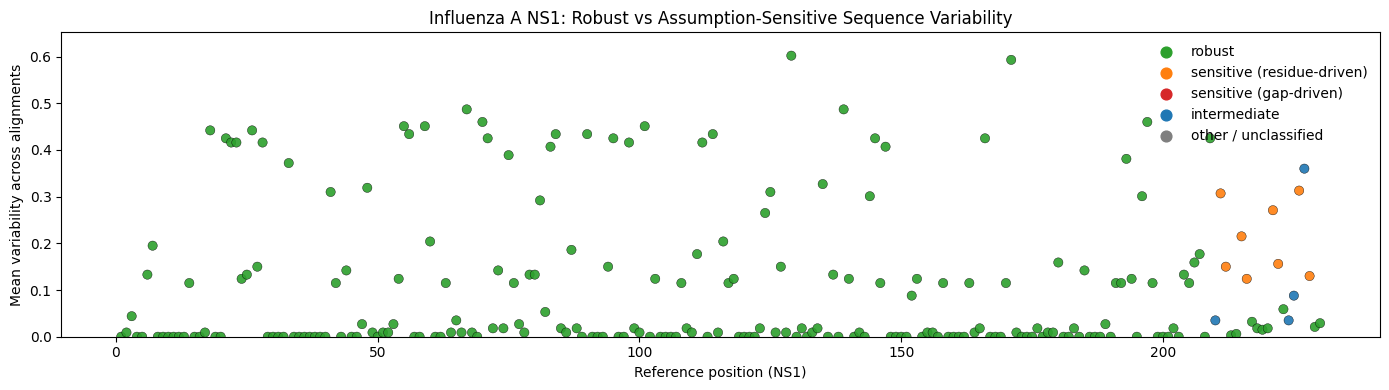

In [ ]:
import matplotlib.pyplot as plt

plot_df = view_mapped.copy()

color_map = {
    "robust": "#2ca02c",
    "sensitive (residue-driven)": "#ff7f0e",
    "sensitive (gap-driven)": "#d62728",
    "intermediate (residue-driven)": "#1f77b4",
    "intermediate (gap-driven)": "#1f77b4",
}

plot_df["color"] = plot_df["class"].apply(lambda x: color_map.get(x, "#7f7f7f"))

plt.figure(figsize=(14,4))
plt.scatter(
    plot_df["ref_pos"],
    plot_df["mean_var"],
    c=plot_df["color"].tolist(),
    s=45,
    alpha=0.9,
    edgecolor="black",
    linewidth=0.3
)

plt.xlabel("Reference position (NS1)")
plt.ylabel("Mean variability across alignments")
plt.title("Influenza A NS1: Robust vs Assumption-Sensitive Sequence Variability")

# legend
plt.scatter([], [], c=color_map["robust"], label="robust", s=60)
plt.scatter([], [], c=color_map["sensitive (residue-driven)"], label="sensitive (residue-driven)", s=60)
plt.scatter([], [], c=color_map["sensitive (gap-driven)"], label="sensitive (gap-driven)", s=60)
plt.scatter([], [], c=color_map["intermediate (residue-driven)"], label="intermediate", s=60)
plt.scatter([], [], c="#7f7f7f", label="other / unclassified", s=60)

plt.legend(frameon=False, loc="upper right")
plt.ylim(0, plot_df["mean_var"].max() + 0.05)
plt.tight_layout()
plt.show()

## Results Overview

Most NS1 positions exhibit stable variability across alignment scenarios.

Assumption-sensitive positions are limited in number and are not uniformly distributed along the sequence.

## Interpretation

For NS1, most observed sequence variability reflects intrinsic residue diversity rather than artifacts of alignment assumptions.

Assumption-sensitive positions identify regions where sequence-based inference is less stable and should be interpreted with caution.

## Limitations

This analysis does not incorporate phylogenetic relationships or functional annotations.

Results depend on the representativeness of available sequence data and the selected alignment parameter ranges.